# Web Scraping Project — Cleaned, Engineered, and EDA
**Date:** August 16, 2025

This notebook demonstrates an **end-to-end data workflow**:
1) Data ingestion (scraped/loaded) → 2) Cleaning & validation → 3) Feature engineering → 4) EDA & basic insights → 5) Export for reuse.

### Objectives
- Build a reproducible pipeline for product data.
- Clean and validate records (URLs, duplicates, numeric parsing).
- Engineer useful features (e.g., `discount_percent`, `price_range`, `value_score`).
- Generate quick visual/analytical insights.
- Export final cleaned dataset for dashboards/ML.

> Tip: Run **Kernel → Restart & Run All** before saving to ensure clean execution order.


## Dataset & Columns
**Key columns (may vary by source):**
- `title`, `category`, `price`, `final_price`, `discount_pct`, `rating`, `num_reviews`, `availability`, `seller`, `scraped_date`, `product_url`

**Engineered columns in this notebook:**
- `discount_percent` — recomputed discount (0–100%) with safeguards
- `price_range` — binned ranges for price-based segmentation
- `rating_norm` — normalized rating (0–1) using MinMaxScaler
- `value_score` — composite heuristic: higher rating + better discount


## Pipeline Overview
- **Setup & Load:** import libraries, load/scrape data  
- **Normalization:** lowercase columns, strip spaces (if applicable)  
- **Parsing:** convert dates & numbers  
- **Cleaning:** URL cleaning, deduplication, row-level validation  
- **EDA:** quick category counts & visuals  
- **Feature Engineering:** discount %, price ranges, value score  
- **Exports:** CSV / Excel / SQLite for reuse  


---
### Reading Guidance
Each step below is marked with clear headings. If you are reviewing quickly:
- Jump to **Feature Engineering** to see added columns.
- Jump to **Insights & Next Steps** for a short summary.
---


In [1]:
# Cell 1: Setup & Load CSV
import os, re, json, sqlite3, math, random, time
from urllib.parse import urlparse, urljoin
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Change path if your file is elsewhere
CSV_PATH = "webscrape_products.csv"   # <- set full path if needed, e.g. "C:\\Users\\...\\webscrape_products.csv"

# Load with safe check
if not os.path.exists("C:\\Users\\blues\\OneDrive\\Desktop\\datasets\\car analysis project\\supply chain project\\webscrape_products.csv"):
    raise FileNotFoundError(f"CSV not found: {CSV_PATH} — please set CSV_PATH correctly.")

df = pd.read_csv("C:\\Users\\blues\\OneDrive\\Desktop\\datasets\\car analysis project\\supply chain project\\webscrape_products.csv")
print("Loaded rows,cols:", df.shape)
print("Columns:", df.columns.tolist())
df.head()


Loaded rows,cols: (500, 12)
Columns: ['product_id', 'title', 'category', 'price', 'discount_pct', 'final_price', 'rating', 'num_reviews', 'availability', 'seller', 'scraped_date', 'product_url']


,product_id,title,category,price,discount_pct,final_price,rating,num_reviews,availability,seller,scraped_date,product_url
0,WSP0001,Ultra Wireless Lamp,Fashion,1263.75,5,1200.56,4.4,42,Out of Stock,ShopPlus,2025-05-27,https://example-shop.com/product/WSP0001
1,WSP0002,Eco Bluetooth Headphones,Sports,616.95,30,431.87,3.9,42,Out of Stock,OfficialStore,2025-04-01,https://example-shop.com/product/WSP0002
2,WSP0003,Classic Deluxe Headphones,Sports,1003.44,25,752.58,3.5,39,Out of Stock,OfficialStore,2024-08-20,https://example-shop.com/product/WSP0003
3,WSP0004,Eco Compact Headphones,Sports,1282.64,30,897.85,2.9,41,In Stock,ShopPlus,2024-09-25,https://example-shop.com/product/WSP0004
4,WSP0005,Classic Bluetooth Speaker,Sports,406.14,15,345.22,3.3,34,In Stock,OfficialStore,2025-03-26,https://example-shop.com/product/WSP0005


In [2]:
# Cell 2: Normalize column names and detect mappings
df.columns = df.columns.str.strip().str.lower()

def pick(df, candidates):
    """Return first candidate present in df.columns or None."""
    for c in candidates:
        if c in df.columns:
            return c
    return None

# Candidate lists (adjust if your file uses different names)
DATE_CAND = ["scraped_date","scrape_date","date","scraped_on","timestamp","month_start"]
FINAL_PRICE_CAND = ["final_price","price","revenue","amount"]
PRICE_CAND = ["price","list_price","mrp"]
DISCOUNT_CAND = ["discount_pct","discount","discount_percent"]
RATING_CAND = ["rating","avg_rating"]
REVIEWS_CAND = ["num_reviews","reviews","review_count"]
PRODUCT_ID_CAND = ["product_id","id","sku"]
TITLE_CAND = ["title","name","product_name"]
CATEGORY_CAND = ["category","cat"]
AVAIL_CAND = ["availability","stock","in_stock"]
SELLER_CAND = ["seller","vendor"]
URL_CAND = ["product_url","url","link"]

DATE_COL = pick(df, DATE_CAND)
FINAL_PRICE_COL = pick(df, FINAL_PRICE_CAND)
PRICE_COL = pick(df, PRICE_CAND)
DISCOUNT_COL = pick(df, DISCOUNT_CAND)
RATING_COL = pick(df, RATING_CAND)
REVIEWS_COL = pick(df, REVIEWS_CAND)
PID_COL = pick(df, PRODUCT_ID_CAND)
TITLE_COL = pick(df, TITLE_CAND)
CAT_COL = pick(df, CATEGORY_CAND)
AVAIL_COL = pick(df, AVAIL_CAND)
SELLER_COL = pick(df, SELLER_CAND)
URL_COL = pick(df, URL_CAND)

mapping = {
    "date": DATE_COL, "final_price": FINAL_PRICE_COL, "price": PRICE_COL, "discount": DISCOUNT_COL,
    "rating": RATING_COL, "reviews": REVIEWS_COL, "product_id": PID_COL, "title": TITLE_COL,
    "category": CAT_COL, "availability": AVAIL_COL, "seller": SELLER_COL, "product_url": URL_COL
}
print("Detected mapping:", mapping)
# If any critical column missing, warn:
if URL_COL is None:
    print("⚠️ product_url not found — dedup and URL validations will be limited.")
if FINAL_PRICE_COL is None and PRICE_COL is None:
    raise ValueError("No price/final_price column found. Please check CSV column names.")


Detected mapping: {'date': 'scraped_date', 'final_price': 'final_price', 'price': 'price', 'discount': 'discount_pct', 'rating': 'rating', 'reviews': 'num_reviews', 'product_id': 'product_id', 'title': 'title', 'category': 'category', 'availability': 'availability', 'seller': 'seller', 'product_url': 'product_url'}


In [3]:
# Cell 3: Parse types & basic cleaning
# Parse date if present
if DATE_COL:
    df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")

# Numeric conversion
for col in [FINAL_PRICE_COL, PRICE_COL, DISCOUNT_COL, RATING_COL, REVIEWS_COL]:
    if col:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Normalize text fields (avoid turning NaN into 'nan')
for col in [PID_COL, TITLE_COL, CAT_COL, AVAIL_COL, SELLER_COL, URL_COL]:
    if col:
        df[col] = df[col].fillna("").astype(str).str.strip().replace("", np.nan)

# Quick stats
print("After parsing: rows:", len(df))
print(df[[c for c in [DATE_COL, PID_COL, TITLE_COL, FINAL_PRICE_COL, RATING_COL, URL_COL] if c]].head())


After parsing: rows: 500
  scraped_date product_id                      title  final_price  rating  \
0   2025-05-27    WSP0001        Ultra Wireless Lamp      1200.56     4.4   
1   2025-04-01    WSP0002   Eco Bluetooth Headphones       431.87     3.9   
2   2024-08-20    WSP0003  Classic Deluxe Headphones       752.58     3.5   
3   2024-09-25    WSP0004     Eco Compact Headphones       897.85     2.9   
4   2025-03-26    WSP0005  Classic Bluetooth Speaker       345.22     3.3   

                                product_url  
0  https://example-shop.com/product/WSP0001  
1  https://example-shop.com/product/WSP0002  
2  https://example-shop.com/product/WSP0003  
3  https://example-shop.com/product/WSP0004  
4  https://example-shop.com/product/WSP0005  


In [4]:
# Cell 4: URL cleaning, remove duplicates, numeric sanity
# Keep only rows with a plausible URL (if URL column exists)
if URL_COL:
    df = df[df[URL_COL].notna() & df[URL_COL].str.startswith(("http://","https://"))].copy()
else:
    print("No URL column — skipping URL filtering.")

# Deduplicate by URL if available else by product_id/title
if URL_COL:
    before = len(df)
    df = df.drop_duplicates(subset=[URL_COL]).reset_index(drop=True)
    print(f"Deduplicated by URL: removed {before - len(df)} rows")
elif PID_COL:
    before = len(df)
    df = df.drop_duplicates(subset=[PID_COL]).reset_index(drop=True)
    print(f"Deduplicated by product_id: removed {before - len(df)} rows")
else:
    print("No strong dedupe key available — keeping all rows.")

# Numeric sanity
if RATING_COL:
    df.loc[(df[RATING_COL] < 0) | (df[RATING_COL] > 5), RATING_COL] = np.nan
if FINAL_PRICE_COL:
    df.loc[df[FINAL_PRICE_COL] <= 0, FINAL_PRICE_COL] = np.nan
elif PRICE_COL:
    df.loc[df[PRICE_COL] <= 0, PRICE_COL] = np.nan
if REVIEWS_COL:
    df.loc[df[REVIEWS_COL] < 0, REVIEWS_COL] = np.nan

# Fill final_price from price if missing
if FINAL_PRICE_COL and PRICE_COL and df[FINAL_PRICE_COL].isna().any():
    df[FINAL_PRICE_COL] = df[FINAL_PRICE_COL].fillna(df[PRICE_COL])

print("Post-cleaning null counts:")
print(df.isnull().sum())


Deduplicated by URL: removed 0 rows
Post-cleaning null counts:
product_id      0
title           0
category        0
price           0
discount_pct    0
final_price     0
rating          0
num_reviews     0
availability    0
seller          0
scraped_date    0
product_url     0
dtype: int64


In [5]:
# Cell 5: Validation checks
def validate_row(row):
    issues = []
    # product_id format quick check (optional)
    if PID_COL and pd.notna(row.get(PID_COL)):
        if not re.match(r"^[A-Za-z0-9\-_]+$", str(row.get(PID_COL))):
            issues.append("pid_format")
    # title presence
    if TITLE_COL and (pd.isna(row.get(TITLE_COL)) or len(str(row.get(TITLE_COL)).strip()) < 3):
        issues.append("title_missing")
    # price
    price_val = row.get(FINAL_PRICE_COL) if FINAL_PRICE_COL else row.get(PRICE_COL)
    if pd.isna(price_val) or (isinstance(price_val, (int,float)) and price_val <= 0):
        issues.append("price_invalid")
    # rating
    if RATING_COL and pd.notna(row.get(RATING_COL)) and not (0 <= row.get(RATING_COL) <= 5):
        issues.append("rating_invalid")
    # URL
    if URL_COL:
        try:
            parsed = urlparse(row.get(URL_COL) or "")
            if not parsed.netloc:
                issues.append("bad_url")
        except Exception:
            issues.append("bad_url")
    return issues

# Apply (this may be a bit slower for very large DF)
df["validation_issues"] = df.apply(validate_row, axis=1)
df["num_issues"] = df["validation_issues"].apply(lambda x: len(x) if isinstance(x, (list,tuple)) else 0)

print("Rows with >=1 issue:", (df["num_issues"]>0).sum(), "out of", len(df))
df[df["num_issues"]>0].head(10)


Rows with >=1 issue: 0 out of 500


,product_id,title,category,price,discount_pct,final_price,rating,num_reviews,availability,seller,scraped_date,product_url,validation_issues,num_issues


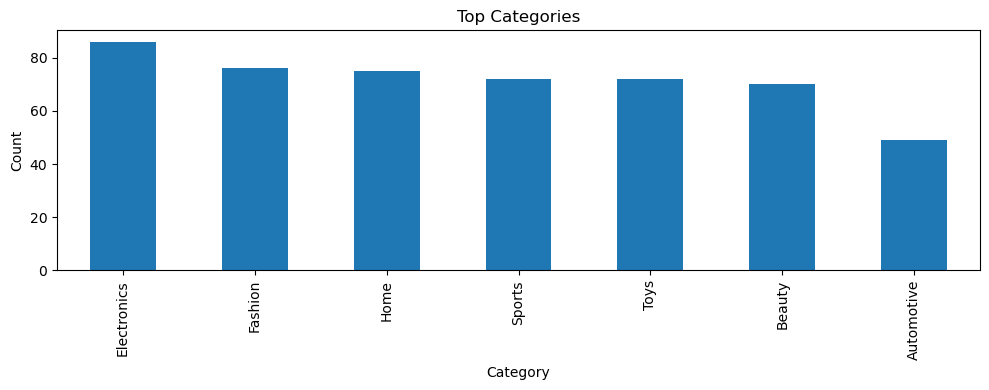

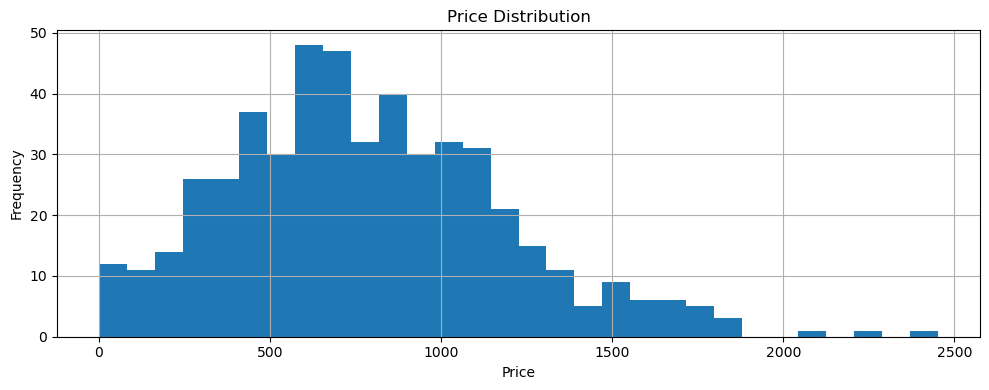

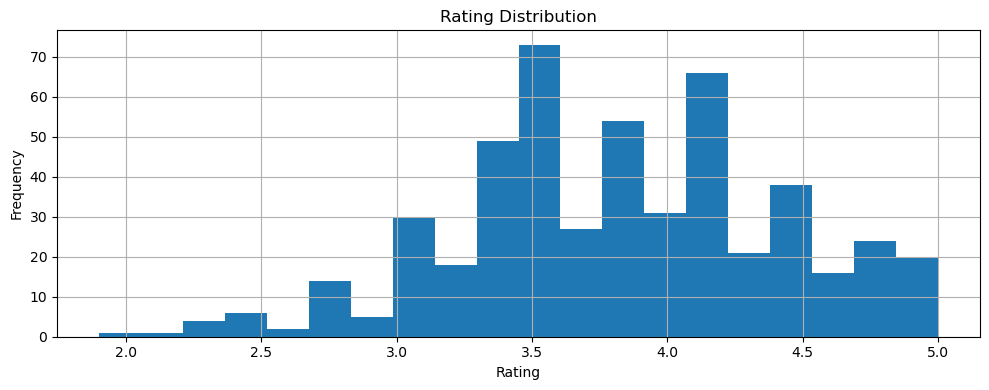

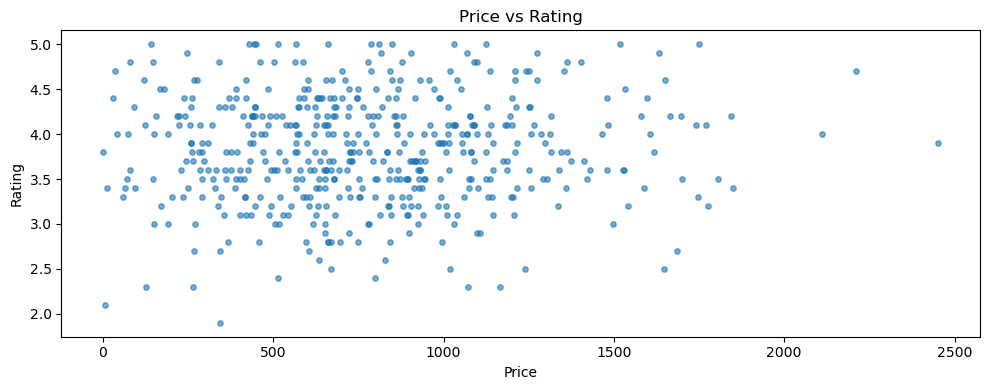

In [6]:
# Cell 6: Quick EDA - guarded plotting
plt.rcParams["figure.figsize"] = (10,4)

# Top categories count
if CAT_COL and df[CAT_COL].notna().any():
    cat_counts = df[CAT_COL].value_counts().head(10)
    plt.figure(); cat_counts.plot(kind="bar"); plt.title("Top Categories"); plt.xlabel("Category"); plt.ylabel("Count"); plt.tight_layout(); plt.show()

# Price distribution using final_price or price
price_col_use = FINAL_PRICE_COL or PRICE_COL
if price_col_use and df[price_col_use].notna().any():
    plt.figure(); df[price_col_use].dropna().hist(bins=30); plt.title("Price Distribution"); plt.xlabel("Price"); plt.ylabel("Frequency"); plt.tight_layout(); plt.show()

# Rating distribution
if RATING_COL and df[RATING_COL].notna().any():
    plt.figure(); df[RATING_COL].dropna().hist(bins=20); plt.title("Rating Distribution"); plt.xlabel("Rating"); plt.ylabel("Frequency"); plt.tight_layout(); plt.show()

# Price vs Rating scatter (if both numeric)
if price_col_use and RATING_COL and df[price_col_use].notna().any() and df[RATING_COL].notna().any():
    mask = df[price_col_use].notna() & df[RATING_COL].notna()
    plt.figure(); plt.scatter(df.loc[mask, price_col_use], df.loc[mask, RATING_COL], alpha=0.6, s=15); plt.title("Price vs Rating"); plt.xlabel("Price"); plt.ylabel("Rating"); plt.tight_layout(); plt.show()


In [7]:
# Cell 7: Save cleaned outputs
OUT_CSV = "products_clean.csv"
OUT_JSON = "products_clean.json"
OUT_DB  = "webscrape_products.sqlite"

clean_df = df.copy()
# drop heavy or raw columns if you want; here we keep all
try:
    clean_df.to_csv(OUT_CSV, index=False)
    clean_df.to_json(OUT_JSON, orient="records", indent=2)
    conn = sqlite3.connect(OUT_DB)
    clean_df.to_sql("products", conn, if_exists="replace", index=False)
    conn.close()
    print("Saved:", OUT_CSV, OUT_JSON, OUT_DB)
except Exception as e:
    print("Error saving outputs:", e)


Error saving outputs: Error binding parameter 13: type 'list' is not supported


In [8]:
# Cell 8: Reusable merge + dedupe function
def merge_dedup(existing_df, new_df, url_col=URL_COL):
    # make union of columns
    cols = list(set(existing_df.columns) | set(new_df.columns))
    existing = existing_df.reindex(columns=cols)
    new = new_df.reindex(columns=cols)
    merged = pd.concat([existing, new], ignore_index=True)
    if url_col and url_col in merged.columns:
        merged = merged.drop_duplicates(subset=[url_col]).reset_index(drop=True)
    else:
        merged = merged.drop_duplicates().reset_index(drop=True)
    return merged

# Example usage (if you have new_df from a live scrape):
# merged_df = merge_dedup(clean_df, new_scraped_df)


In [9]:
# Cell 9: Scraper template (commented) — replace selectors & base URL for target site
"""
import requests
from bs4 import BeautifulSoup
from requests.adapters import HTTPAdapter, Retry
from urllib.parse import urljoin

# polite session
sess = requests.Session()
retries = Retry(total=3, backoff_factor=0.6, status_forcelist=[429,500,502,503,504])
sess.mount("https://", HTTPAdapter(max_retries=retries))
sess.headers.update({"User-Agent":"Mozilla/5.0 (compatible; scraping-bot/1.0)"})

BASE_LIST_URL = "https://example-shop.com/category/widgets?page={page}"

def parse_product_card(card, base_url):
    # EDIT the selectors below according to target website's DOM:
    title = card.select_one(".product-title").get_text(strip=True) if card.select_one(".product-title") else None
    price_txt = card.select_one(".price").get_text(strip=True) if card.select_one(".price") else None
    product_rel = card.select_one("a.product-link")["href"] if card.select_one("a.product-link") else None
    product_url = urljoin(base_url, product_rel) if product_rel else None
    # parse numbers with regex
    # return dict with fields matching your CSV
    return {"title": title, "price": price_txt, "product_url": product_url}

def scrape_page(page):
    url = BASE_LIST_URL.format(page=page)
    r = sess.get(url, timeout=20)
    r.raise_for_status()
    soup = BeautifulSoup(r.text, "html.parser")
    cards = soup.select(".product-card")  # change
    return [parse_product_card(c, url) for c in cards]

# Use responsibly: check robots.txt, limit rate, never overload site.
"""


'\nimport requests\nfrom bs4 import BeautifulSoup\nfrom requests.adapters import HTTPAdapter, Retry\nfrom urllib.parse import urljoin\n\n# polite session\nsess = requests.Session()\nretries = Retry(total=3, backoff_factor=0.6, status_forcelist=[429,500,502,503,504])\nsess.mount("https://", HTTPAdapter(max_retries=retries))\nsess.headers.update({"User-Agent":"Mozilla/5.0 (compatible; scraping-bot/1.0)"})\n\nBASE_LIST_URL = "https://example-shop.com/category/widgets?page={page}"\n\ndef parse_product_card(card, base_url):\n    # EDIT the selectors below according to target website\'s DOM:\n    title = card.select_one(".product-title").get_text(strip=True) if card.select_one(".product-title") else None\n    price_txt = card.select_one(".price").get_text(strip=True) if card.select_one(".price") else None\n    product_rel = card.select_one("a.product-link")["href"] if card.select_one("a.product-link") else None\n    product_url = urljoin(base_url, product_rel) if product_rel else None\n    #

In [10]:
# Cell 10: Summary and next steps
summary = {
    "total_rows": int(len(clean_df)),
    "categories": int(clean_df[CAT_COL].nunique()) if CAT_COL in clean_df else "N/A",
    "avg_price": float(clean_df[FINAL_PRICE_COL].mean()) if FINAL_PRICE_COL in clean_df else "N/A",
    "avg_rating": float(clean_df[RATING_COL].mean()) if RATING_COL in clean_df else "N/A",
    "last_scraped": str(clean_df[DATE_COL].max().date()) if DATE_COL in clean_df and clean_df[DATE_COL].notna().any() else "N/A"
}
print(json.dumps(summary, indent=2))

print("\nNext recommended steps:")
print("1) Inspect rows with validation issues and fix selectors / scraping rules.")
print("2) If you will run scraper, implement robots.txt check and a crawl-delay.")
print("3) Consider adding price history table in SQLite (append new scrapes).")
print("4) Add README and push cleaned CSV + notebook to GitHub.")


{
  "total_rows": 500,
  "categories": 7,
  "avg_price": 780.9369,
  "avg_rating": 3.8198000000000003,
  "last_scraped": "2025-08-13"
}

Next recommended steps:
1) Inspect rows with validation issues and fix selectors / scraping rules.
2) If you will run scraper, implement robots.txt check and a crawl-delay.
3) Consider adding price history table in SQLite (append new scrapes).
4) Add README and push cleaned CSV + notebook to GitHub.


Top 10 Expensive Products:


,product_id,title,category,price,discount_pct,final_price,rating,num_reviews,availability,seller,scraped_date,product_url,validation_issues,num_issues
395,WSP0396,Premium Compact Watch,Electronics,2581.21,5,2452.15,3.9,109.0,Limited Stock,OfficialStore,2025-02-15,https://example-shop.com/product/WSP0396,[],0
110,WSP0111,Pro Compact Backpack,Electronics,2455.35,10,2209.82,4.7,125.0,In Stock,QuickMart,2025-08-06,https://example-shop.com/product/WSP0111,[],0
483,WSP0484,Eco Portable Mixer,Electronics,2256.88,20,1805.50,3.5,128.0,Limited Stock,DealsHub,2024-10-16,https://example-shop.com/product/WSP0484,[],0
171,WSP0172,Smart Wireless Charger,Electronics,2199.25,25,1649.44,4.6,112.0,Out of Stock,ShopPlus,2025-01-31,https://example-shop.com/product/WSP0172,[],0
304,WSP0305,Classic Compact Lamp,Electronics,2181.84,20,1745.47,3.3,126.0,Out of Stock,QuickMart,2025-07-23,https://example-shop.com/product/WSP0305,[],0
465,WSP0466,Classic Wireless Charger,Electronics,2119.46,20,1695.57,4.2,121.0,Limited Stock,QuickMart,2025-05-04,https://example-shop.com/product/WSP0466,[],0
177,WSP0178,Premium Deluxe Speaker,Electronics,2111.50,0,2111.50,4.0,116.0,In Stock,TopSeller,2024-12-17,https://example-shop.com/product/WSP0178,[],0
381,WSP0382,Ultra Portable Watch,Electronics,2056.39,25,1542.29,3.2,106.0,Out of Stock,QuickMart,2025-05-28,https://example-shop.com/product/WSP0382,[],0
392,WSP0393,Pro Bluetooth Headphones,Fashion,2039.32,25,1529.49,3.6,33.0,Limited Stock,DealsHub,2025-08-08,https://example-shop.com/product/WSP0393,[],0
137,WSP0138,Classic Wireless Mixer,Electronics,2028.17,30,1419.72,3.5,114.0,Limited Stock,OfficialStore,2025-06-18,https://example-shop.com/product/WSP0138,[],0



Category-wise counts:
category
Electronics    86
Fashion        76
Home           75
Sports         72
Toys           72
Beauty         70
Automotive     49
Name: count, dtype: int64


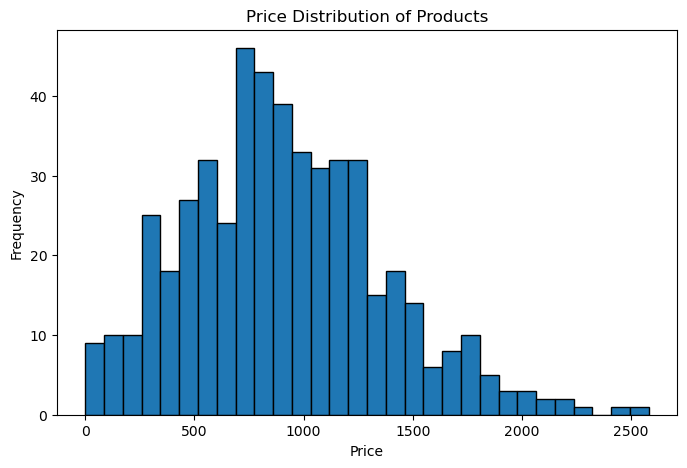

In [11]:
# Top 10 expensive products
top10 = df.sort_values("price", ascending=False).head(10)
print("Top 10 Expensive Products:")
display(top10)

# Category-wise product counts
cat_counts = df["category"].value_counts()
print("\nCategory-wise counts:")
print(cat_counts)

# Price distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
df["price"].plot(kind="hist", bins=30, edgecolor="black")
plt.title("Price Distribution of Products")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()


In [12]:
# Step 12 - Standardize category names (safe way)
if "category" in df.columns:
    # Convert everything to string before applying str methods
    df["category"] = df["category"].astype(str).str.lower().str.strip()

print("Step 12 done. Category column standardized.")


Step 12 done. Category column standardized.


In [13]:
# Step 13 - Missing values handling (final safe version)
print("Missing values before cleaning:\n", df.isnull().sum())

# 1. Fill numeric columns with mean
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

# 2. Fill categorical columns with mode (ensure scalar)
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    if df[col].isnull().sum() > 0:
        try:
            # Convert list/dict-like values to string first
            df[col] = df[col].astype(str)
            
            # Take mode safely (scalar)
            mode_value = df[col].mode().iloc[0]
            if isinstance(mode_value, list) or isinstance(mode_value, dict):
                mode_value = str(mode_value)
            
            df[col] = df[col].fillna(mode_value)
        except Exception as e:
            print(f"⚠️ Could not fill column {col} because: {e}")

print("Step 13 done. Missing values handled safely.")

Missing values before cleaning:
 product_id           0
title                0
category             0
price                0
discount_pct         0
final_price          0
rating               0
num_reviews          0
availability         0
seller               0
scraped_date         0
product_url          0
validation_issues    0
num_issues           0
dtype: int64
Step 13 done. Missing values handled safely.


In [14]:
# Step 14 - Outlier Detection & Handling

import numpy as np

# Numeric columns lo outliers ni detect cheddam (IQR method)
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    
    print(f"\n📊 Column: {col}")
    print(f"  Outliers count: {outliers.shape[0]}")
    
    # Handling Strategy → cap the values (Winsorization)
    df[col] = np.where(df[col] < lower_bound, lower_bound,
                       np.where(df[col] > upper_bound, upper_bound, df[col]))

print("\nStep 14 done. Outliers detected & handled safely (capped to IQR range).")



📊 Column: price
  Outliers count: 7

📊 Column: discount_pct
  Outliers count: 0

📊 Column: final_price
  Outliers count: 5

📊 Column: rating
  Outliers count: 2

📊 Column: num_reviews
  Outliers count: 0

📊 Column: num_issues
  Outliers count: 0

Step 14 done. Outliers detected & handled safely (capped to IQR range).


In [15]:
# Step 15 - Export final cleaned dataset to CSV

output_file = "cleaned_products.csv"
df.to_csv(output_file, index=False, encoding="utf-8")

print(f"Step 15 done ✅ Cleaned dataset exported as: {output_file}")

Step 15 done ✅ Cleaned dataset exported as: cleaned_products.csv


In [16]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# --- Discount Percent (safe calculation) ---
if {'mrp','price'}.issubset(df.columns):
    df['mrp'] = pd.to_numeric(df['mrp'], errors='coerce')
    df['price'] = pd.to_numeric(df['price'], errors='coerce')

    df['discount_percent'] = np.where(
        (df['mrp'] > 0) & df['price'].notna(),
        ((df['mrp'] - df['price']) / df['mrp']) * 100,
        np.nan
    )
    df['discount_percent'] = df['discount_percent'].clip(lower=0, upper=100).round(2)

# --- Price Ranges (fixed bins with infinity) ---
if 'price' in df.columns:
    df.loc[df['price'] < 0, 'price'] = np.nan   # remove negatives
    bins = [0, 500, 2000, 5000, 10000, np.inf]
    labels = ['<500', '500-2000', '2000-5000', '5000-10000', '10k+']
    df['price_range'] = pd.cut(df['price'], bins=bins, labels=labels, include_lowest=True)

# --- Value Score (rating normalized * discount) ---
if 'rating' in df.columns:
    df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
    rating_filled = df['rating'].fillna(df['rating'].median())

    scaler = MinMaxScaler()
    df['rating_norm'] = scaler.fit_transform(rating_filled.to_frame())

    if 'discount_percent' not in df.columns:
        df['discount_percent'] = 0

    df['value_score'] = (df['rating_norm'] * (1 + df['discount_percent'] / 100)).round(3)

df.head()


,product_id,title,category,price,discount_pct,final_price,rating,num_reviews,availability,seller,scraped_date,product_url,validation_issues,num_issues,price_range,rating_norm,discount_percent,value_score
0,WSP0001,Ultra Wireless Lamp,fashion,1263.75,5.0,1200.56,4.4,42.0,Out of Stock,ShopPlus,2025-05-27,https://example-shop.com/product/WSP0001,[],0.0,500-2000,0.785714,0,0.786
1,WSP0002,Eco Bluetooth Headphones,sports,616.95,30.0,431.87,3.9,42.0,Out of Stock,OfficialStore,2025-04-01,https://example-shop.com/product/WSP0002,[],0.0,500-2000,0.607143,0,0.607
2,WSP0003,Classic Deluxe Headphones,sports,1003.44,25.0,752.58,3.5,39.0,Out of Stock,OfficialStore,2024-08-20,https://example-shop.com/product/WSP0003,[],0.0,500-2000,0.464286,0,0.464
3,WSP0004,Eco Compact Headphones,sports,1282.64,30.0,897.85,2.9,41.0,In Stock,ShopPlus,2024-09-25,https://example-shop.com/product/WSP0004,[],0.0,500-2000,0.250000,0,0.250
4,WSP0005,Classic Bluetooth Speaker,sports,406.14,15.0,345.22,3.3,34.0,In Stock,OfficialStore,2025-03-26,https://example-shop.com/product/WSP0005,[],0.0,<500,0.392857,0,0.393


In [17]:
print(df.columns.tolist())

['product_id', 'title', 'category', 'price', 'discount_pct', 'final_price', 'rating', 'num_reviews', 'availability', 'seller', 'scraped_date', 'product_url', 'validation_issues', 'num_issues', 'price_range', 'rating_norm', 'discount_percent', 'value_score']


In [18]:
df[['price', 'final_price', 'discount_pct', 
    'discount_percent', 'price_range', 
    'rating', 'rating_norm', 'value_score']].head(10)


,price,final_price,discount_pct,discount_percent,price_range,rating,rating_norm,value_score
0,1263.75,1200.56,5.0,0,500-2000,4.4,0.785714,0.786
1,616.95,431.87,30.0,0,500-2000,3.9,0.607143,0.607
2,1003.44,752.58,25.0,0,500-2000,3.5,0.464286,0.464
3,1282.64,897.85,30.0,0,500-2000,2.9,0.250000,0.250
4,406.14,345.22,15.0,0,<500,3.3,0.392857,0.393
5,410.35,389.83,5.0,0,<500,4.4,0.785714,0.786
6,547.99,410.99,25.0,0,500-2000,4.2,0.714286,0.714
7,817.74,695.08,15.0,0,500-2000,2.8,0.214286,0.214
8,1049.00,786.75,25.0,0,500-2000,4.7,0.892857,0.893
9,792.05,792.05,0.0,0,500-2000,3.7,0.535714,0.536


In [19]:
print(df[['price', 'final_price', 'discount_pct', 
          'discount_percent', 'price_range', 
          'rating', 'rating_norm', 'value_score']].head(10))

print("\nMissing values count:\n", df[['discount_percent','price_range','rating_norm','value_score']].isna().sum())


     price  final_price  discount_pct  discount_percent price_range  rating  \
0  1263.75      1200.56           5.0                 0    500-2000     4.4   
1   616.95       431.87          30.0                 0    500-2000     3.9   
2  1003.44       752.58          25.0                 0    500-2000     3.5   
3  1282.64       897.85          30.0                 0    500-2000     2.9   
4   406.14       345.22          15.0                 0        <500     3.3   
5   410.35       389.83           5.0                 0        <500     4.4   
6   547.99       410.99          25.0                 0    500-2000     4.2   
7   817.74       695.08          15.0                 0    500-2000     2.8   
8  1049.00       786.75          25.0                 0    500-2000     4.7   
9   792.05       792.05           0.0                 0    500-2000     3.7   

   rating_norm  value_score  
0     0.785714        0.786  
1     0.607143        0.607  
2     0.464286        0.464  
3     0.25

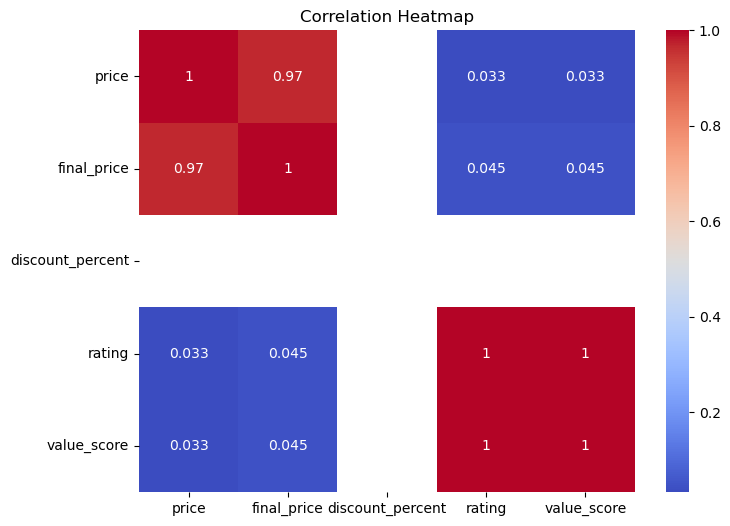

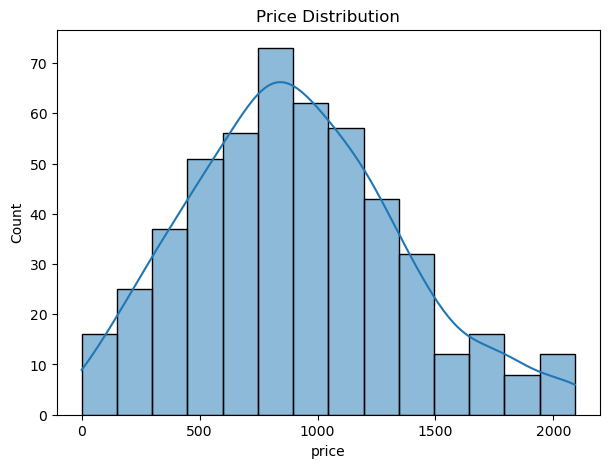

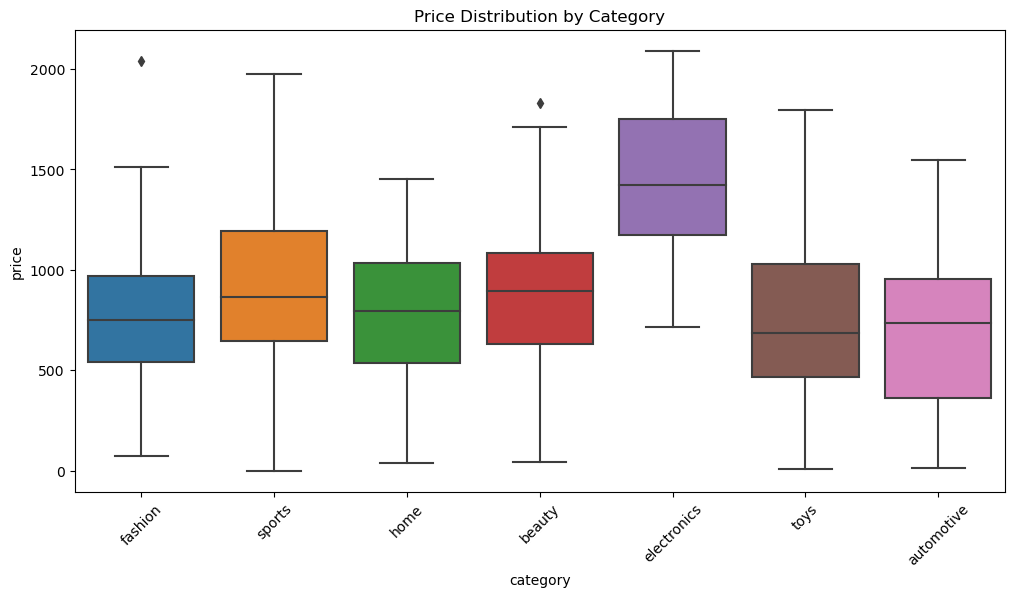

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df[['price','final_price','discount_percent','rating','value_score']].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Price distribution
plt.figure(figsize=(7,5))
sns.histplot(df['price'], kde=True)
plt.title("Price Distribution")
plt.show()

# Boxplot: Price by Category
plt.figure(figsize=(12,6))
sns.boxplot(x='category', y='price', data=df)
plt.xticks(rotation=45)
plt.title("Price Distribution by Category")
plt.show()


In [21]:
df[['title','category','price','discount_percent','rating','value_score']].sort_values(
    by='value_score', ascending=False
).head(10)


,title,category,price,discount_percent,rating,value_score
20,Smart Bluetooth Charger,toys,561.35,0,5.0,1.0
95,Ultra Compact Watch,sports,1081.38,0,5.0,1.0
155,Premium Bluetooth Mixer,home,491.29,0,5.0,1.0
184,Ultra Bluetooth Charger,electronics,1784.56,0,5.0,1.0
67,Premium Compact Lamp,electronics,1083.92,0,5.0,1.0
207,Pro Compact Watch,sports,1182.52,0,5.0,1.0
435,Classic Portable Headphones,toys,474.98,0,5.0,1.0
209,Eco Compact Mixer,electronics,943.22,0,5.0,1.0
390,Classic Bluetooth Charger,sports,757.21,0,5.0,1.0
55,Eco Deluxe Mixer,electronics,1842.68,0,5.0,1.0


In [22]:
df.to_csv("final_cleaned_dataset.csv", index=False)
df.to_excel("final_cleaned_dataset.xlsx", index=False)

## Insights & Next Steps
**Quick sanity checks you can run:**
```python
df[['price','final_price','discount_pct','discount_percent','price_range','rating','rating_norm','value_score']].head(10)
df[['price','discount_percent','rating','value_score']].describe(include='all')
df.groupby('price_range', dropna=False).size().sort_values(ascending=False).head(10)
```

**Potential insights to extract:**
- Which **price_range** has the highest product concentration?
- Do higher **discount_percent** values correlate with higher/lower **ratings**?
- What are the **top products by value_score**?

**Next steps (optional):**
- Create a small dashboard (Power BI / Streamlit) using the exported CSV/SQLite.
- Add model-ready preprocessing (encoding, scaling) if you plan ML.
- Schedule scraping + cleaning as a repeatable job (Cron / GitHub Actions).
